# Experiments

## Dataset 1 - Breast Cancer

In [1]:
from sklearn.datasets import load_breast_cancer
X, Y = load_breast_cancer(return_X_y=True)

## Preparing data

In [2]:
from sklearn.preprocessing import OneHotEncoder
from collinearity import SelectNonCollinear
from sklearn.preprocessing import StandardScaler
import numpy as np

def remove_missing_rows(X, Y):
    mask = np.isnan(X).sum(axis=1) == 0
    return X[mask], Y[mask]

def encode_categorical(X):
    mask = np.array([isinstance(x, str) for x in X[0]])
    if mask.sum() > 0:    
        X = X[:, mask]
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(X)
        X = enc.transform(X).toarray()
    return X

def remove_colinear(X, correlation_threshold=0.9):
    # Source: https://github.com/gianlucamalato/collinearity
    # 1. Take the couple of features that have the lowest absolute 
    #    value of the linear correlation coefficient.
    # 2. If it's lower than the threshold, consider these features
    # 3. Keep adding features as long as the correlation matrix doesn't
    #    show off-diagonal elements whose absolute value is greater than the threshold.
    selector = SelectNonCollinear(correlation_threshold=correlation_threshold)
    selector.fit(X, y=None)
    X = selector.transform(X)
    columns_selection = selector.get_support()
    return X, columns_selection   

def scale_features(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

Before preparation:

In [3]:
print(f"In the raw data, there are {X.shape[0]} observations and {X.shape[1]} features.")

In the raw data, there are 569 observations and 30 features.


Dropping rows with missing values, encoding categorical variables, dropping features with correlation > 0.9, and scaling the data.

In [4]:
X, Y = remove_missing_rows(X, Y)
X = encode_categorical(X)
X, columns_selection = remove_colinear(X, correlation_threshold=0.9)

After preparation:

In [5]:
print(f"In the prepared data, there are {X.shape[0]} observations and {X.shape[1]} features (removed {len(columns_selection) - np.array(columns_selection).sum()} features).")

In the prepared data, there are 569 observations and 21 features (removed 9 features).


### Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Models and metrics

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from LogisticRegressionIRLS import LR
from sklearn.neighbors import KNeighborsClassifier
from functools import partial

models = {'LDA': LinearDiscriminantAnalysis,
        'QDA': QuadraticDiscriminantAnalysis,
        'Logistic Regression': LogisticRegression,
        'Logistic Regression IRLS': partial(LR, maximisation_minorisation=True),
        'KNN': KNeighborsClassifier}

In [8]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

metrics = {'precision': partial(precision_score, zero_division=0),
            'recall': recall_score,
            'accuracy': accuracy_score,
            'f1': f1_score}

## Experiments

Test run.

In [9]:
import pandas as pd
from warnings import simplefilter
import re
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)

def train_model(model, X_train, X_test, Y_train, Y_test, metrics, model_name='model'):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return {'model':model_name} | {metric: metrics[metric](Y_test, Y_pred) for metric in metrics}

def train_models(models, X, Y, metrics, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    results = []
    for model_name, model_class in models.items():
        results.append(train_model(model_class(), X_train, X_test, Y_train, Y_test, metrics, model_name=model_name))
    df = pd.DataFrame(results)
    return df

df = train_models(models, X, Y, metrics, test_size=0.2)
df

Algorithm didn't converge! Iteration limit reached!


,model,precision,recall,accuracy,f1
0,LDA,0.958333,1.000000,0.973684,0.978723
1,QDA,0.984848,0.942029,0.956140,0.962963
2,Logistic Regression,0.943662,0.971014,0.947368,0.957143
3,Logistic Regression IRLS,1.000000,0.826087,0.894737,0.904762
4,KNN,0.916667,0.956522,0.921053,0.936170


Repeated 10 times to create boxplots.

In [10]:
test_size = 0.6 # it is this high to see differences in the results

df_list = []
for i in range(50):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm didn't converge! Iteration limit reached!
Algorithm di

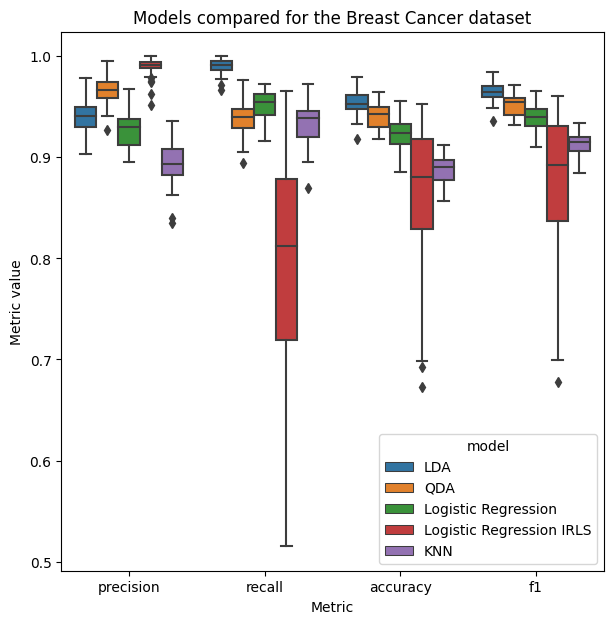

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model')

ax.set_title('Models compared for the Breast Cancer dataset')
ax.set_xlabel('Metric')
ax.set_ylabel('Metric value')
plt.show()